<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/Week_4/SanneAartsML2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# %pip install tensorflow==2.3.0
# %pip install gym==0.22
# %pip install keras
%pip install keras-rl2==1.0.4

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential
from keras.layers import Dense,  Flatten
from keras.optimizers import Adam
import os

from rl.agents import DQNAgent
from rl.policy import EpsGreedyQPolicy, BoltzmannQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory

In [4]:
ENV_NAME = "CartPole-v1"
EPISODES = 1000
MAX_RUNS = 10
MAX_STEPS = 10000
BATCH_SIZE = 50
MEMORY_SIZE = 10000
# MEMORY_SIZE = 10000
TARGET_MODEL_UPDATE = 1000
GAMMA = 0.99
LEARNING_RATE = 1e-3
MAX_EXPLORATION_RATE = 1
MIN_EXPLORATION_RATE = 0.01
EXPLORATION_RATE_DECAY = 0.995

#### Bellman Equation

\begin{equation}
Q_{new}(s, a)=Q(s,a)+\alpha \left[ r(s,a)+ \gamma * max_{a'}(Q'(s',a'))-Q(s,a)\right] \hspace{1em}
\begin{array}{rl}
Q_{new}:& \text{New Q value}\\
Q:& \text{Current Q value}\\
s:& \text{State}\\
a:& \text{Action}\\
\alpha:& \text{Learning Rate}\\
r:& \text{reward}\\
\gamma:& \text{Discount rate}\\
max(Q'(s',a')):& \text{Maximum expected future reward}\\
\end{array} 
\tag{1}
\end{equation}
#### Loss function

\begin{equation}
L=\frac{1}{2}\left[r+\gamma max_{a'}(Q'(s',a'))-Q(s,a) \right]^2 
\tag{2}
\end{equation}

In [58]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000000)

        self.gamma = 0.95
        self.exploration_rate = 1.0
        self.exploration_rate_decay = 0.990
        self.exploration_rate_min = 0.01
        self.learning_rate = 0.001
        self.batch_size = 50
        self.episodes = 300
        self.model = self.build_model()
        self.rewards = []

    def build_model(self):
        # Building Network
        # Create a Sequential model using keras
        model = Sequential()
        #Input - 4 different states 
        model.add(Dense(24, activation='relu', input_shape=(self.state_size,)))
        # model.add(Flatten(input_shape=(1,self.state_size)))
        model.add(Dense(24, activation='relu'))
        # model.add(Dense(24, activation='relu'))
        # Output - one node for each possible action, the one with the 
        # highest output value will be be returned as action
        model.add(Dense(self.action_size, activation='linear'))
        # model.compile(loss='mse', optimizer=RMSprop(lr=LEARNING_RATE))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))
    
    # def decay(self):
    #     # Decrease the exploration rate
    #     self.exploration_rate *= self.exploration_rate_decay
    #     self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        
    def train(self, batch_size):
        if len(self.memory) < self.batch_size:
            # We haven't experienced enough to properly learn yet - keep exploring!
            return
        # Randomly sample a minibatch from the memory
        minibatch = random.sample(self.memory, batch_size)
        # Initiate variables to store inputs and targets for training the model
        inputs = np.zeros((batch_size, self.state_size))
        targets = np.zeros((batch_size, self.action_size))
        # For all individual memories we initiate a round of training
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            # Store the current memory in the inputs and targets arrays
            inputs[i] = state
            # if the memory was the final step of the episode, we know that the highest possible q value
            # this episode is equal to the reward
            # otherwise we should also consider the maximum discounted future reward
            # which is given by the second term in eq 1
            q_update = reward 
            if not done:  
                q_update =(reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            # We then run the predict method again, for the current state, storing the outputs for
            # both left and right in the variable target_f
            q_values = self.model.predict(state)
            # replace the target output with the actual reward 
            q_values[0][action] = q_update
            # Store the updated q_values in the targets array
            targets[i] = q_values
            self.rewards.append(q_update)
        # Train the model on the inputs and targets arrays
            self.model.fit(inputs, targets, batch_size=batch_size, verbose=1)
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

    def act(self, state):
        # Greedy Epsilon policy, a random number between 0 and 1 is selected, if the number is smaller
        # than the exploration rate,a random action is selected from the available actions
        if np.random.rand() <= self.exploration_rate:
            action = random.randrange(self.action_size)
        # otherwise the aaction with the highest predicted Q-value is selected 
        else:
            # state is passed into the predict method to get the predicted Q value for
            # all possible actions (here, to go left or right)
            act_values = self.model.predict(state)
            # since we get two outputs, we want to select the action corresponding to the highest value
            action= np.argmax(act_values[0])
        return action

In [ ]:
# output_dir = "model_output/cartpole/"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)


# class DQNAgent:
#     def __init__(self, state_size, action_size):
#         self.state_size = state_size
#         self.action_size = action_size
#         self.memory = deque(maxlen=1000000)

#         self.gamma = 0.95
#         self.exploration_rate = 1.0
#         self.exploration_rate_decay = 0.995
#         self.exploration_rate_min = 0.01
#         self.learning_rate = 0.001
#         self.batch_size = 20
#         self.episodes = 150
#         self.model = self.build_model()

#     def build_model(self):
#         # Building Network
#         # Create a Sequential model using keras
#         model = Sequential()
#         #Input - 4 different states 
#         model.add(Dense(24,activation='relu',input_shape=(self.state_size,)))
#         # model.add(Flatten(input_shape=(1,self.state_size)))
#         model.add(Dense(24, activation='relu'))
#         # model.add(Dense(24, activation='relu'))
#         # Output - one node for each possible action, the one with the 
#         # highest output value will be be returned as action
#         model.add(Dense(self.action_size, activation='linear'))
#         # model.compile(loss='mse', optimizer=RMSprop(lr=LEARNING_RATE))
#         model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
#         return model
    
#     def remember(self, state, action, reward, next_state, done): 
#         self.memory.append((state, action,
#                             reward, next_state, done))
#     def decay(self):
#          # As the model gains experience, we want it to start using its experience 
#          # more and more so we slowly want to decrease the exploration rate 
#         #  if self.exploration_rate > self.exploration_rate_min:
#         self.exploration_rate *= self.exploration_rate_decay
#         self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        
#     def train(self, batch_size):
#         # randomly sample a minibatch from the memory, we need to do this randomly since
#         # sequential measurements become more similar later on
#         minibatch = random.sample(self.memory, batch_size)
#         # For all individual memories we initiate a round of training
#         for state, action, reward, next_state, done in minibatch:
#                 # if the memory was the final step of the episode, we know that the highest possible q value
#                 # this episode is equal to the reward
#                 # otherwise we should also consider the maximum discounted future reward
#                 # which is given by the second term in eq 1
#                 q_update = reward 
#                 if not done:  
#                     q_update =(reward + self.gamma *np.amax(self.model.predict(next_state)[0]))
#                 # We then run the predict method again, for the current state, storing the outputs for
#                 # both left and right in the variable target_f
#                 q_values = self.model.predict(state)
#                 # replace the target output with the actual reward 
#                 q_values[0][action] = q_update
#                 # actually training the model
#                 self.model.fit(state, q_values, verbose=1) 

#         self.decay()

#     def act(self, state):
#         # Greedy Epsilon policy, a random number between 0 and 1 is selected, if the number is smaller
#         # than the exploration rate,a random action is selected from the available actions
#         if np.random.rand() <= self.exploration_rate:
#             action = random.randrange(self.action_size)
#         # otherwise the aaction with the highest predicted Q-value is selected 
#         else:
#             # state is passed into the predict method to get the predicted Q value for
#             # all possible actions (here, to go left or right)
#             act_values = self.model.predict(state)
#             # since we get two outputs, we want to select the action corresponding to the highest value
#             action= np.argmax(act_values[0])
#         return action

#     def save(self, name): 
#         self.model.save_weights(name)
    

In [15]:
# def cartpole():
#     n_episodes = 300
#     batch_size = 50
#     env = gym.make('CartPole-v1')
#     state_size = env.observation_space.shape[0]
#     action_size = env.action_space.n
#     agent = DQNAgent(state_size,action_size)
#     log = []
#     scores = []
#     run = 0
#     for episode in range(n_episodes):
#         # Initiate the episode in a random state
#         run+=1
#         state = env.reset()
#         # the Keras neural network is expecting a row vector
#         # so we turn the column vector into a row vector
#         state = np.reshape(state, [1,state_size])

#         done = False
#         time = 0
#         # if the episode is not done, we iterate over the different timesteps
#         score = 0
#         while not done:
#             time += 1
#             # passing the state into the act method of the agent, this returns
#             # a 0 (left) or 1 (right)
#             action = agent.act(state)
#             # we still need to apply it to the environment, which will return the 
#             # next_state, the current reward and an update to the boolean that 
#             # represents the state of the game, along with some other irrelevant data that we dont store
#             next_state, reward, done, _ = env.step(action)
#             # If the run was not the last of the episode the model is rewarded, ie. a positive reward
#             # otherwise we subtract the reward, this disincentivises terminating the episode early
#             reward = reward if not done else - reward
#             score += reward
#             # We once again have to reshape the input 
#             next_state = np.reshape(next_state, [1,state_size])
#             # We store the current state, the action taken, the reward it led to, the next state and the boolean done
#             # in the memory of the agent
#             agent.remember(state, action, reward, next_state, done)
#             # prepare the next iteration, corresponding to time+1 by setting the state equal to the next state
#             state = next_state
#             # print summary
#             if done:
#                 print(f"episode: {episode}/{n_episodes}, time: {time}, e: {agent.exploration_rate}")
#                 # log.append(time)
#                 log +=[time]

#                 break
#             # increment our time counter
#         # to increase the training speed of each episode, we can decrease the frequeny with which we call the train function,
#         # note that because of this, it may take more episodes to solve    
#         if len(agent.memory) > batch_size:
#             agent.train(batch_size) 
           
#         # Every 50 episodes, store the parameters
#         # if episode % 50 == 0:
#         #     agent.save(output_dir + "weights_"
#         #             + f"{episode}" + ".hdf5")
#     plt.plot(log)
#     # print(agent.memory[2])
#     env.close()

In [60]:
class cartpole:
    def __init__(self):
        self.n_episodes = 300
        self.max_steps_per_episode = 5000
        self.batch_size = 1
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.agent = DQNAgent(self.state_size,self.action_size)
    
    
    def runEpisode(self):
        rewards = []   
        state = self.env.reset()
        # the Keras neural network is expecting a row vector
        # so we turn the column vector into a row vector
        state = np.reshape(state, [1,self.state_size])
        for i in range(self.max_steps_per_episode):
            
        # done = False
        time = 0
        # if the episode is not done, we iterate over the different timesteps
        score = 0
        while True:
            time += 1
            # passing the state into the act method of the agent, this returns
            # a 0 (left) or 1 (right)
            action = self.agent.act(state)
            # we still need to apply it to the environment, which will return the 
            # next_state, the current reward and an update to the boolean that 
            # represents the state of the game, along with some other irrelevant data that we dont store
            next_state, reward, done, _ = self.env.step(action)
            # If the run was not the last of the episode the model is rewarded, ie. a positive reward
            # otherwise we subtract the reward, this disincentivises terminating the episode early
            reward = reward if not done else - reward
            # We once again have to reshape the input 
            next_state = np.reshape(next_state, [1,state_size])
            # We store the current state, the action taken, the reward it led to, the next state and the boolean done
            # in the memory of the agent
            agent.remember(state, action, reward, next_state, done)
            # prepare the next iteration, corresponding to time+1 by setting the state equal to the next state
            state = next_state
            # print summary
            if done:
                epsilons.append(agent.exploration_rate)
                score.append(reward)
                # print(f"episode: {episode}/{n_episodes}, time: {time}, e: {agent.exploration_rate}")
                # log.append(time)
                log +=[time]

                break
            # increment our time counter
        # to increase the training speed of each episode, we can decrease the frequeny with which we call the train function,
        # note that because of this, it may take more episodes to solve    
        if len(agent.memory) > batch_size:
            agent.train(batch_size) 
        
        # Every 50 episodes, store the parameters
        # if episode % 50 == 0:
        #     agent.save(output_dir + "weights_"
        #             + f"{episode}" + ".hdf5")
    plt.plot(agent.rewards)
    # print(agent.memory[2])
    env.close()

c:\Users\Sanne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\Sanne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 1 samples
1/1 [==============================] - 0s 442ms/sample - loss: 0.4920
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 0.4899
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 0.6466
Train on 1 samples
1/1 [==============================] - 0s 3ms/sample - loss: 0.6987
Train on 1 samples
1/1 [==============================] - 0s 3ms/sample - loss: 0.4837
Train on 1 samples
1/1 [==============================] - 0s 4ms/sample - loss: 0.6040
Train on 1 samples
1/1 [==============================] - 0s 3ms/sample - loss: 0.4981
Train on 1 samples
1/1 [==============================] - 0s 3ms/sample - loss: 0.5216
Train on 1 samples
1/1 [==============================] - 0s 4ms/sample - loss: 0.4892
Train on 1 samples
1/1 [==============================] - 0s 3ms/sample - loss: 0.5018
Train on 1 samples
1/1 [==============================] - 0s 3ms/sample - loss: 0.5140
Train on 1 samples
1/1 [=================

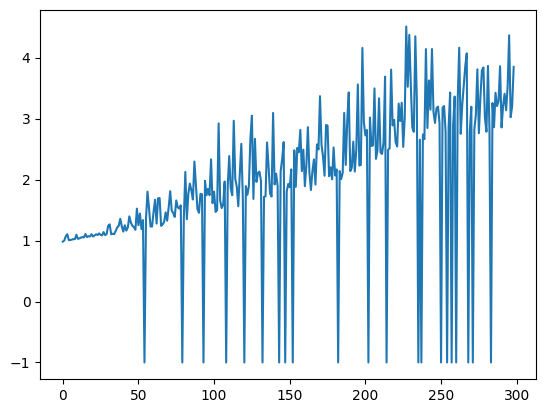

In [61]:
cartpole()

## The cartPole
### Action space
<ul>
<li>push left - 0</li>
<li>push right - 1</li>
</ul>

### Observation space
|num|Observation|Values|Episode terminates for:|
|-|-|-|-|
|0|Cart position|$\pm$ 4.8|$\lvert x \rvert > 2.4$|
|1|Cart Velocity|$\pm \infty$||
|2|Pole Angle|$\pm$ 24 $^ \circ$|$\lvert \theta \rvert > 12 ^\circ $|
|3|Pole Angular Velocity|$\pm\infty$||


## Agent

$$loss=\left(r+\gamma max \hat{Q}(s,a')-Q(s,a\right)^2$$